Will use device: cpu, torch dtype: torch.float32


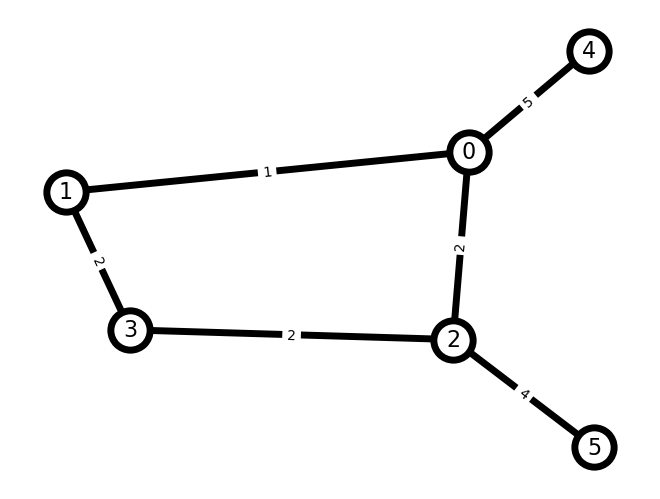

In [1]:
%load_ext autoreload
%autoreload 2
from GraphCreator import *
from utils import *
from itertools import permutations
import matplotlib.pyplot as plt
import pickle
from torch_geometric.nn import GCNConv

# Neural Network Model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GCNSoftmax(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, dropout, device):
        super(GCNSoftmax, self).__init__()
        self.dropout_frac = dropout
        self.conv1 = GraphConv(in_feats, hidden_size).to(device)
        self.conv2 = GraphConv(hidden_size, num_classes).to(device)

    def forward(self, g, inputs, terminals=None):
        # Basic forward pass
        h = self.conv1(g, inputs)
        h = F.relu(h)
        h = F.dropout(h, p=self.dropout_frac, training=self.training)
        h = self.conv2(g, h)
        h = F.softmax(h, dim=1)  # Apply softmax over the classes dimension

        # Handling terminals if provided
        if terminals is not None:
            # Clone h to avoid in-place operations
            h_clone = h.clone()
            # Ensure terminals is a dictionary with node index as keys and target class as values
            for node_index, class_index in terminals.items():
                # Create a one-hot encoded vector for the terminal node's class
                terminal_vector = torch.zeros(h.shape[1], device=h.device)
                terminal_vector[class_index] = 1
                # Use indexing that does not modify the original tensor in-place
                h_clone[node_index] = terminal_vector
            h = h_clone

        return h

# Training Neural network

In [14]:
import torch
from time import time

def run_gnn_training(dataset, net, optimizer, number_epochs, tol, patience, loss_func,  total_classes=3, save_directory=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}

    for epoch in range(number_epochs):
        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph) in dataset.items():

            # create random terminal node for each dataset graph
            if key not in terminal_configs:
                terminal_configs[key] = generate_terminal_nodes(dgl_graph, total_classes, total_classes)
            terminal_nodes = terminal_configs[key]

            # test why we are using randn?
            # inputs = torch.randn(graph.number_of_nodes(), dim_embedding, device=torch_device, dtype=torch_dtype)

            embed = nn.Embedding(graph.number_of_nodes(), dim_embedding)
            embed = embed.type(torch_dtype).to(torch_device)
            inputs = embed.weight

            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, inputs, terminal_nodes)

            # Compute the loss
            loss = loss_func(logits, adjacency_matrix)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()

            # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        # Early stopping break from the outer loop
        if count >= patience:
            break

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'inputs':inputs}
                torch.save(checkpoint, save_directory)

    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')

    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'inputs':inputs}
        torch.save(checkpoint, save_directory)

    return net, best_loss, epoch, inputs


def run_gnn_training2(dataset, net, optimizer, number_epochs, tol, patience, loss_func,  total_classes=3, save_directory=None):
    """
    Train a GCN model with early stopping.
    """
    # loss for a whole epoch
    prev_loss = float('inf')  # Set initial loss to infinity for comparison
    count = 0  # Patience counter
    best_loss = float('inf')  # Initialize best loss to infinity
    best_model_state = None  # Placeholder for the best model state
    loss_list = []
    epochList = []

    t_gnn_start = time()

    # contains information regarding all terminal nodes for the dataset
    terminal_configs = {}
    epochCount = 0

    for epoch in range(number_epochs):
        cumulative_loss = 0.0  # Reset cumulative loss for each epoch

        for key, (dgl_graph, adjacency_matrix,graph, A, C) in dataset.items():
            epochCount +=1
            # create random terminal node for each dataset graph
            if key not in terminal_configs:
                terminal_configs[key] = generate_terminal_nodes(dgl_graph, total_classes, total_classes)
            terminal_nodes = terminal_configs[key]

            # test why we are using randn?
            # inputs = torch.randn(graph.number_of_nodes(), dim_embedding, device=torch_device, dtype=torch_dtype)

            embed = nn.Embedding(graph.number_of_nodes(), dim_embedding)
            embed = embed.type(torch_dtype).to(torch_device)
            inputs = embed.weight

            # Ensure model is in training mode
            net.train()

            # Pass the graph and the input features to the model
            logits = net(dgl_graph, inputs, terminal_nodes)

            # Compute the loss
            loss = loss_func(logits, adjacency_matrix, A, C)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update cumulative loss
            cumulative_loss += loss.item()



            # Check for early stopping
            if epoch > 0 and (cumulative_loss > prev_loss or abs(prev_loss - cumulative_loss) <= tol):
                count += 1
                if count >= patience: # play around with patience value, try lower one
                    print(f'Stopping early at epoch {epoch}')
                    break
            else:
                count = 0  # Reset patience counter if loss decreases

            # Update best model
            if cumulative_loss < best_loss:
                best_loss = cumulative_loss
                best_model_state = net.state_dict()  # Save the best model state

        loss_list.append(loss)

        # Early stopping break from the outer loop
        if count >= patience:
            break

        prev_loss = cumulative_loss  # Update previous loss

        if epoch % 100 == 0:  # Adjust printing frequency as needed
            print(f'Epoch: {epoch}, Cumulative Loss: {cumulative_loss}')

            if save_directory != None:
                checkpoint = {
                    'epoch': epoch,
                    'model': net.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'inputs':inputs}
                torch.save(checkpoint, save_directory)

    t_gnn = time() - t_gnn_start

    # Load the best model state
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    print(f'GNN training took {round(t_gnn, 3)} seconds.')
    print(f'Best cumulative loss: {best_loss}')

    if save_directory != None:
        checkpoint = {
            'epoch': epoch,
            'model': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'inputs':inputs}
        torch.save(checkpoint, save_directory)

    return net, best_loss, epoch, inputs, loss_list


## HyperParameters initialization and related functions

In [4]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=7,patience=1000)
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding+1,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

In [5]:
# Construct graph to learn on
# def get_gnn(n_nodes, gnn_hypers, opt_params, torch_device, torch_dtype):
#     """
#     Generate GNN instance with specified structure. Creates GNN, retrieves embedding layer,
#     and instantiates ADAM optimizer given those.
#
#     Input:
#         n_nodes: Problem size (number of nodes in graph)
#         gnn_hypers: Hyperparameters relevant to GNN structure
#         opt_params: Hyperparameters relevant to ADAM optimizer
#         torch_device: Whether to load pytorch variables onto CPU or GPU
#         torch_dtype: Datatype to use for pytorch variables
#     Output:
#         net: GNN instance
#         embed: Embedding layer to use as input to GNN
#         optimizer: ADAM optimizer instance
#     """
#     dim_embedding = gnn_hypers['dim_embedding']
#     hidden_dim = gnn_hypers['hidden_dim']
#     dropout = gnn_hypers['dropout']
#     number_classes = gnn_hypers['number_classes']
#
#     # instantiate the GNN
#     net = GCNSoftmax(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
#     net = net.type(torch_dtype).to(torch_device)
#     embed = nn.Embedding(n_nodes, dim_embedding)
#     embed = embed.type(torch_dtype).to(torch_device)
#
#     # set up Adam optimizer
#     params = chain(net.parameters(), embed.parameters())
#     optimizer = torch.optim.Adam(params, **opt_params)
#     return net, embed, optimizer

def get_gnn(gnn_hypers, opt_params, torch_device, torch_dtype):
    """
    Adjusted to remove dependency on n_nodes for embedding layer initialization.
    """
    dim_embedding = gnn_hypers['dim_embedding']
    hidden_dim = gnn_hypers['hidden_dim']
    dropout = gnn_hypers['dropout']
    number_classes = gnn_hypers['number_classes']

    # instantiate the GNN without embedding layer dependency on n_nodes
    net = GCNSoftmax(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
    net = net.type(torch_dtype)

    # set up Adam optimizer
    optimizer = torch.optim.Adam(net.parameters(), **opt_params)
    return net, optimizer
net, optimizer = get_gnn( gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)


In [6]:
def LoadNeuralModel(model, gnn_hypers, torch_device, model_location):
    checkpoint = torch.load(model_location)
    #model = checkpoint['model']
    # instantiate the GNN
    # model.load_state_dict(torch.load(model_location))
    model.load_state_dict(checkpoint['model'])
    model.eval()

    return model, checkpoint['inputs']


def printCombo(orig):
    # Original dictionary
    input_dict = orig

    # Generate all permutations of the dictionary values
    value_permutations = list(permutations(input_dict.values()))

    # Create a list of dictionaries from the permutations
    permuted_dicts = [{key: value for key, value in zip(input_dict.keys(), perm)} for perm in value_permutations]

    return permuted_dicts

def GetOptimalNetValue(net, dgl_graph, inp, q_torch, terminal_dict):
    net.eval()
    best_loss = float('inf')

    # find all potential combination of terminal nodes with respective indices
    perm_items = printCombo(terminal_dict)
    for i in perm_items:
        probs = net(dgl_graph, inp, i)
        binary_partitions = (probs >= 0.5).float()
        #print(q_torch, binary_partitions)
        cut_value_item = calculateAllCut(q_torch, binary_partitions)
        if cut_value_item < best_loss:
            best_loss = cut_value_item
    return best_loss



In [7]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

# Hamiltonian loss function

In [8]:
def calculate_HA_vectorized(s):
    """
    Vectorized calculation of HA.
    :param s: A binary matrix of size |V| x |K| where s[i][j] is 1 if vertex i is in partition j.
    :return: The HA value.
    """
    # HA = ∑v∈V(∑k∈K(sv,k)−1)^2
    HA = torch.sum((torch.sum(s, axis=1) - 1) ** 2)
    return HA

def calculate_HC_vectorized_old(s, adjacency_matrix):
    """
    Vectorized calculation of HC.
    :param s: A binary matrix of size |V| x |K|.
    :param adjacency_matrix: A matrix representing the graph where the value at [i][j] is the weight of the edge between i and j.
    :return: The HC value.
    """
    # HC = ∑(u,v)∈E(1−∑k∈K(su,k*sv,k))*adjacency_matrix[u,v]
    K = s.shape[1]
    # Outer product to find pairs of vertices in the same partition and then weight by the adjacency matrix
    prod = adjacency_matrix * (1 - s @ s.T)
    HC = torch.sum(prod)
    return HC

def calculate_HC_vectorized(s, adjacency_matrix):
    """
    Vectorized calculation of HC for soft partitioning.
    :param s: A probability matrix of size |V| x |K| where s[i][j] is the probability of vertex i being in partition j.
    :param adjacency_matrix: A matrix representing the graph where the value at [i][j] is the weight of the edge between i and j.
    :return: The HC value.
    """
    # Initialize HC to 0
    HC = 0

    # Iterate over each partition to calculate its contribution to HC
    for k in range(s.shape[1]):
        # Compute the probability matrix for partition k
        partition_prob_matrix = s[:, k].unsqueeze(1) * s[:, k].unsqueeze(0)

        # Compute the contribution to HC for partition k
        HC_k =adjacency_matrix * (1 - partition_prob_matrix)
        # Sum up the contributions for partition k
        HC += torch.sum(HC_k, dim=(0, 1))

    # Since we've summed up the partition contributions twice (due to symmetry), divide by 2
    HC = HC / 2

    return HC

def Loss(s, adjacency_matrix,  A=1, C=1):
    HA = calculate_HA_vectorized(s)
    HC = calculate_HC_vectorized(s, adjacency_matrix)

    return A * HA + C * HC


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import chain

# Assuming the existence of createGraph, createGDLGraph, and createAdjancenyMatrix functions
# Assuming the definition of GCNSoftmax, loss_func, and terminal_nodes is available

def process_graph_with_gcn(graph_size, net, dim_embedding, torch_dtype, torch_device):


    # Create graph
    graph = CreateGraph(graph_size)
    dgl_graph = dgl.from_networkx(graph)
    dgl_graph = dgl_graph.to(TORCH_DEVICE)
    adjacency_matrix = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    terminal_configs = {}

    terminal_configs[graph_size] = generate_terminal_nodes(dgl_graph, 3, 3)
    terminal_nodes = terminal_configs[graph_size]
    # Initialize inputs with random features for each node
    inputs = torch.randn(graph_size, dim_embedding, device=torch_device, dtype=torch_dtype)

    # Forward pass through the model
    net.train()
    logits = net(dgl_graph, inputs, terminal_nodes)  # Assuming terminal_nodes setup
    loss = Loss(logits, adjacency_matrix)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

# Model setup
dim_embedding = 64  # Example fixed size for embedding dimension
hidden_dim = 32  # Example hidden layer size
number_classes = 3  # For a 3-way cut
dropout = 0.5  # Dropout rate
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch_dtype = torch.float

# Initialize the GCN model
net = GCNSoftmax(dim_embedding, hidden_dim, number_classes, dropout, torch_device)
net = net.type(torch_dtype).to(torch_device)

# Setup optimizer (assuming the model parameters include those from an embedding if used)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)  # Example learning rate

# Process graphs of different sizes
for graph_size in [30, 50]:
    loss = process_graph_with_gcn(graph_size, net, dim_embedding, torch_dtype, torch_device)
    print(f"Processed graph size {graph_size} with loss: {loss}")


Number of edges: 385
Sample edges: [(0, 1, {'weight': 98, 'capacity': 98}), (0, 2, {'weight': 16, 'capacity': 16}), (0, 3, {'weight': 58, 'capacity': 58}), (0, 4, {'weight': 49, 'capacity': 49}), (0, 5, {'weight': 13, 'capacity': 13})]
Processed graph size 30 with loss: 53085.9140625
Number of edges: 1110
Sample edges: [(0, 1, {'weight': 25, 'capacity': 25}), (0, 2, {'weight': 50, 'capacity': 50}), (0, 3, {'weight': 35, 'capacity': 35}), (0, 5, {'weight': 32, 'capacity': 32}), (0, 6, {'weight': 76, 'capacity': 76})]
Processed graph size 50 with loss: 145955.34375


(None,
 tensor([[ 0., 10.,  0.,  0.,  0.,  0.,  0.],
         [10.,  0.,  1.,  0.,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  1.,  0.,  1.,  0.],
         [ 0.,  0.,  1.,  0., 10.,  0.,  0.],
         [ 0.,  0.,  0., 10.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  0.,  0.,  0., 10.],
         [ 0.,  0.,  0.,  0.,  0., 10.,  0.]]))

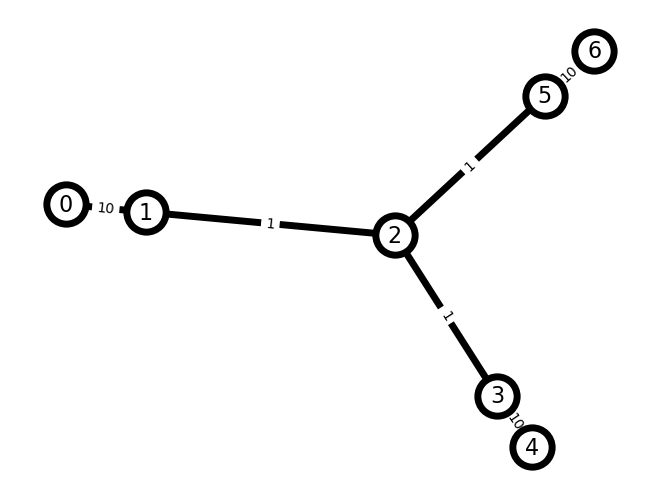

In [10]:
edges = [(0,1, {"weight": 10, "capacity":10}),
         (1,2, {"weight": 1, "capacity":1}),
         (2,3, {"weight": 1, "capacity":1}),
         (3,4, {"weight": 10, "capacity":10}),
         (2,5, {"weight": 1, "capacity":1}),
         (5,6, {"weight": 10, "capacity":10}),]
graph = CreateDummyFunction(edges)
graph_dgl = dgl.from_networkx(nx_graph=graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

DrawGraph(graph), q_torch

In [11]:
m = torch.tensor( [[1., 0., 0.],
                   [0., 1., 0.],
                   [0., 1., 0.],
                   [0., 1., 0.],
                   [0., 1., 0.],
                   [0., 0., 1.],
                   [0., 0., 1.]])

find3WayCut(graph, [0,1,6]), calculateAllCut(q_torch,m)

(11, tensor(11., dtype=torch.float64))

# Generating Data
## Experiment 1

Creating training set with the following constraints:
- Each graph have precisey 30 nodes
- Each graph has random edges (50% edges connected)
- Each edge has random value of 1-10

In [20]:
datasetItem = {}
for i in range(1000):


    graph = CreateGraph(30)
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    datasetItem[i] = [graph_dgl, q_torch, graph]

Number of edges: 387
Sample edges: [(0, 1, {'weight': 8, 'capacity': 8}), (0, 2, {'weight': 2, 'capacity': 2}), (0, 3, {'weight': 2, 'capacity': 2}), (0, 4, {'weight': 1, 'capacity': 1}), (0, 5, {'weight': 9, 'capacity': 9})]
Number of edges: 400
Sample edges: [(0, 1, {'weight': 6, 'capacity': 6}), (0, 2, {'weight': 8, 'capacity': 8}), (0, 3, {'weight': 2, 'capacity': 2}), (0, 4, {'weight': 1, 'capacity': 1}), (0, 5, {'weight': 5, 'capacity': 5})]
Number of edges: 383
Sample edges: [(0, 1, {'weight': 8, 'capacity': 8}), (0, 2, {'weight': 7, 'capacity': 7}), (0, 3, {'weight': 6, 'capacity': 6}), (0, 4, {'weight': 3, 'capacity': 3}), (0, 5, {'weight': 1, 'capacity': 1})]
Number of edges: 400
Sample edges: [(0, 2, {'weight': 9, 'capacity': 9}), (0, 4, {'weight': 1, 'capacity': 1}), (0, 5, {'weight': 4, 'capacity': 4}), (0, 6, {'weight': 10, 'capacity': 10}), (0, 8, {'weight': 1, 'capacity': 1})]
Number of edges: 396
Sample edges: [(0, 1, {'weight': 4, 'capacity': 4}), (0, 2, {'weight': 7,

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


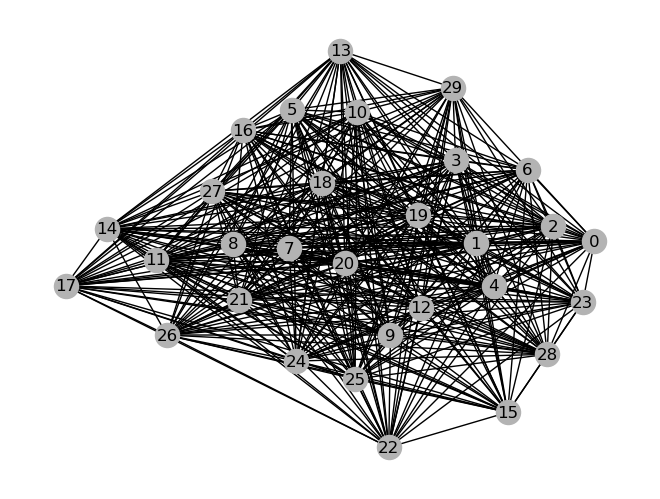

In [21]:
print(datasetItem[1][2].nodes)
# Visualize graph
pos = nx.kamada_kawai_layout(datasetItem[1][2])
nx.draw(datasetItem[1][2], pos, with_labels=True, node_color=[[.7, .7, .7]])

### Neural Network Training

In [23]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=30,patience=100)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, optimizer = get_gnn( gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

terminal_nodes = 3

trained_net, bestLost, epoch, inp= run_gnn_training(
    datasetItem, net, optimizer, int(1e3),
    gnn_hypers['tolerance'], gnn_hypers['patience'], Loss, gnn_hypers['number_classes'], './exp1.pth')


Epoch: 0, Cumulative Loss: 5722158.13671875
Epoch: 100, Cumulative Loss: 4583352.0
Epoch: 200, Cumulative Loss: 4583352.0
Epoch: 300, Cumulative Loss: 4583352.0
Epoch: 400, Cumulative Loss: 4583352.0
Epoch: 500, Cumulative Loss: 4583352.0
Epoch: 600, Cumulative Loss: 4583352.0
Epoch: 700, Cumulative Loss: 4583352.0
Epoch: 800, Cumulative Loss: 4583352.0
Epoch: 900, Cumulative Loss: 4583352.0
GNN training took 2768.121 seconds.
Best cumulative loss: 4283.0


### Testing on exp1

Number of edges: 43
Sample edges: [(0, 1, {'weight': 98, 'capacity': 98}), (0, 2, {'weight': 17, 'capacity': 17}), (0, 3, {'weight': 15, 'capacity': 15}), (0, 4, {'weight': 75, 'capacity': 75}), (0, 5, {'weight': 1, 'capacity': 1})]
Heurestic 3-way min-cut value: 738
Neural Network 3-way min-cut value: tensor(738., dtype=torch.float64)


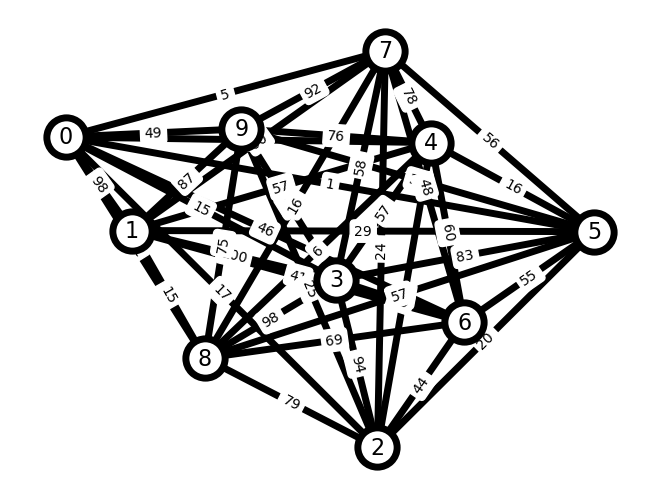

In [14]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=30,patience=1000)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net,  optimizer = get_gnn(gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
# load nerual network model for evaluation
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './exp1.pth')
model.eval()

#create dummy graph
graph = CreateGraph(10)
dgl_graph = dgl.from_networkx(nx_graph=graph)
dgl_graph = dgl_graph.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

DrawGraph(graph)

embed = nn.Embedding(graph.number_of_nodes(), dim_embedding)
embed = embed.type(torch_dtype).to(torch_device)
inputs = embed.weight
# find min cut
print("Heurestic 3-way min-cut value: " + str(find3WayCut(graph, [0,5,9])))
print("Neural Network 3-way min-cut value: " + str(GetOptimalNetValue(model,dgl_graph, inputs, q_torch, {0:0, 5:1, 9:2})))
#print( inputs, q_torch, inputs.size())


In [15]:
test_item = {}
for i in range(10):


    graph = CreateGraph(10)
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    test_item[i] = [graph_dgl, q_torch, graph]

for key, (dgl_graph, adjacency_matrix,graph) in test_item.items():
    # inputs = torch.randn(graph.number_of_nodes(), dim_embedding, device=torch_device, dtype=torch_dtype)
    embed = nn.Embedding(graph.number_of_nodes(), dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight
    print("Neural Network 3-way min-cut value: " + str(GetOptimalNetValue(model,dgl_graph, inputs, adjacency_matrix, {0:0, 5:1, 9:2})))
    print("Heurestic 3-way min-cut value: " + str(find3WayCut(graph, [0,5,9])))

    print(f'-------')


Number of edges: 42
Sample edges: [(0, 2, {'weight': 87, 'capacity': 87}), (0, 3, {'weight': 96, 'capacity': 96}), (0, 4, {'weight': 91, 'capacity': 91}), (0, 5, {'weight': 74, 'capacity': 74}), (0, 6, {'weight': 26, 'capacity': 26})]
Number of edges: 41
Sample edges: [(0, 1, {'weight': 66, 'capacity': 66}), (0, 2, {'weight': 17, 'capacity': 17}), (0, 3, {'weight': 83, 'capacity': 83}), (0, 4, {'weight': 24, 'capacity': 24}), (0, 5, {'weight': 80, 'capacity': 80})]
Number of edges: 41
Sample edges: [(0, 1, {'weight': 41, 'capacity': 41}), (0, 2, {'weight': 27, 'capacity': 27}), (0, 3, {'weight': 62, 'capacity': 62}), (0, 4, {'weight': 73, 'capacity': 73}), (0, 5, {'weight': 45, 'capacity': 45})]
Number of edges: 42
Sample edges: [(0, 1, {'weight': 99, 'capacity': 99}), (0, 2, {'weight': 50, 'capacity': 50}), (0, 3, {'weight': 84, 'capacity': 84}), (0, 4, {'weight': 98, 'capacity': 98}), (0, 5, {'weight': 70, 'capacity': 70})]
Number of edges: 42
Sample edges: [(0, 1, {'weight': 48, 'ca

## Experiment 2

Creating training set with the following constraints:
- Each graph have precisey 100 nodes
- Each graph has random edges (50% probability of edge creation)
- Each edge has random value of 1-500

In [12]:
datasetItem = {}
for i in range(1000):


    graph = CreateGraph(random.randint(100, 200))
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    datasetItem[i] = [graph_dgl, q_torch, graph]
    print("Graph Number Created: "+str(i))

Number of edges: 11162
Sample edges: [(0, 2, {'weight': 98, 'capacity': 98}), (0, 4, {'weight': 45, 'capacity': 45}), (0, 5, {'weight': 43, 'capacity': 43}), (0, 6, {'weight': 36, 'capacity': 36}), (0, 7, {'weight': 68, 'capacity': 68})]
Graph Number Created: 0
Number of edges: 6003
Sample edges: [(0, 1, {'weight': 69, 'capacity': 69}), (0, 2, {'weight': 82, 'capacity': 82}), (0, 3, {'weight': 58, 'capacity': 58}), (0, 4, {'weight': 2, 'capacity': 2}), (0, 5, {'weight': 85, 'capacity': 85})]
Graph Number Created: 1
Number of edges: 4444
Sample edges: [(0, 1, {'weight': 95, 'capacity': 95}), (0, 2, {'weight': 50, 'capacity': 50}), (0, 3, {'weight': 87, 'capacity': 87}), (0, 4, {'weight': 65, 'capacity': 65}), (0, 5, {'weight': 48, 'capacity': 48})]
Graph Number Created: 2
Number of edges: 16484
Sample edges: [(0, 1, {'weight': 10, 'capacity': 10}), (0, 2, {'weight': 12, 'capacity': 12}), (0, 3, {'weight': 29, 'capacity': 29}), (0, 4, {'weight': 1, 'capacity': 1}), (0, 5, {'weight': 75, 

In [12]:
save_object(datasetItem, './datasetItem_exp2.pkl')


NameError: name 'datasetItem' is not defined

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]


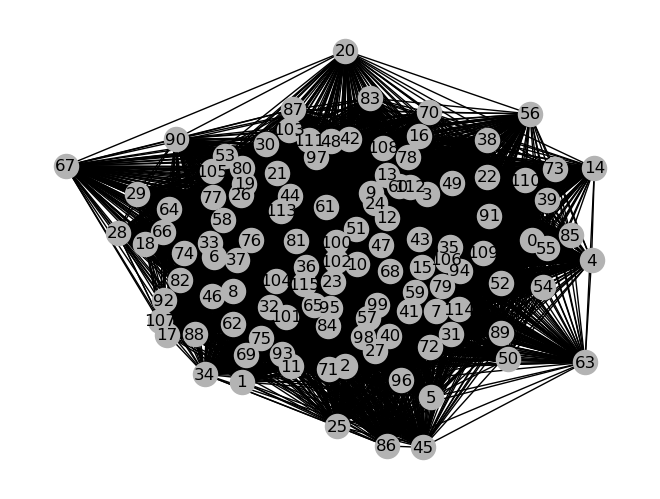

In [15]:

print(dst[1][2].nodes)
# Visualize graph
pos = nx.kamada_kawai_layout(dst[1][2])
nx.draw(dst[1][2], pos, with_labels=True, node_color=[[.7, .7, .7]])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]


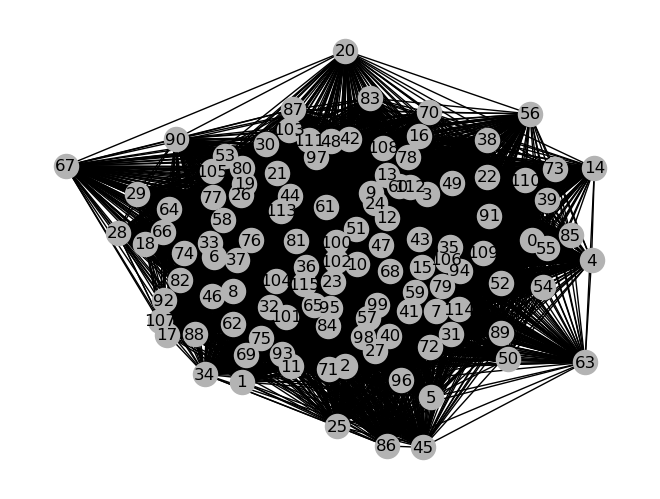

In [38]:
print(datasetItem[1][2].nodes)
# Visualize graph
pos = nx.kamada_kawai_layout(datasetItem[1][2])
nx.draw(datasetItem[1][2], pos, with_labels=True, node_color=[[.7, .7, .7]])

In [17]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=100,patience=50)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, optimizer = get_gnn( gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

terminal_nodes = 3

trained_net, bestLost, epoch, inp= run_gnn_training(
    datasetItem, net, optimizer, int(1e3),
    gnn_hypers['tolerance'], gnn_hypers['patience'], Loss, gnn_hypers['number_classes'], './exp2_new_embedding.pth')


Epoch: 0, Cumulative Loss: 1413503298.5
Epoch: 100, Cumulative Loss: 1083251774.0
Epoch: 200, Cumulative Loss: 1083251774.0
Epoch: 300, Cumulative Loss: 1083251774.0
Epoch: 400, Cumulative Loss: 1083251774.0
Epoch: 500, Cumulative Loss: 1083251774.0
Epoch: 600, Cumulative Loss: 1083251774.0
Epoch: 700, Cumulative Loss: 1083251774.0
Epoch: 800, Cumulative Loss: 1083251774.0
Epoch: 900, Cumulative Loss: 1083251774.0
GNN training took 22947.849 seconds.
Best cumulative loss: 1145389.0


In [39]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=100,patience=50)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

datasetItem = {}

net, optimizer = get_gnn( gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

terminal_nodes = 3

trained_net, bestLost, epoch, inp= run_gnn_training2(
    datasetItem, net, optimizer, int(1e3),
    gnn_hypers['tolerance'], gnn_hypers['patience'], Loss, gnn_hypers['number_classes'], './exp2_exist_embedding.pth')


Epoch: 0, Cumulative Loss: 1418628439.1875
Epoch: 100, Cumulative Loss: 1083423566.0
Epoch: 200, Cumulative Loss: 1083423566.0
Epoch: 300, Cumulative Loss: 1083423566.0
Epoch: 400, Cumulative Loss: 1083423566.0
Epoch: 500, Cumulative Loss: 1083423566.0
Epoch: 600, Cumulative Loss: 1083423566.0
Epoch: 700, Cumulative Loss: 1083423566.0
Epoch: 800, Cumulative Loss: 1083423566.0
Epoch: 900, Cumulative Loss: 1083423566.0
GNN training took 9285.79 seconds.
Best cumulative loss: 1139619.0


In [23]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=100,patience=20)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, optimizer = get_gnn( gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

datasetItem = {}
print(dst[0])
for key, (dgl_graph, adjacency_matrix,graph) in dst.items():
    A, C = FIndAC(graph)
    datasetItem[key] = [dgl_graph, adjacency_matrix, graph, A, C]

terminal_nodes = 3


trained_net, bestLost, epoch, inp, loss_lst= run_gnn_training2(
    datasetItem, net, optimizer, int(1e3),
    gnn_hypers['tolerance'], gnn_hypers['patience'], Loss, gnn_hypers['number_classes'], './exp2_new_AC.pth')


[Graph(num_nodes=158, num_edges=22324,
      ndata_schemes={}
      edata_schemes={}), tensor([[ 0.,  0., 98.,  ..., 83., 73., 38.],
        [ 0.,  0., 77.,  ...,  3.,  4., 96.],
        [98., 77.,  0.,  ..., 77., 78., 14.],
        ...,
        [83.,  3., 77.,  ...,  0., 45., 41.],
        [73.,  4., 78.,  ..., 45.,  0., 99.],
        [38., 96., 14.,  ..., 41., 99.,  0.]]), <networkx.classes.graph.Graph object at 0x32c8448e0>]
Epoch: 0, Cumulative Loss: 108896287590.0
Epoch: 100, Cumulative Loss: 83315436886.0
Epoch: 200, Cumulative Loss: 83315436886.0
Epoch: 300, Cumulative Loss: 83315436886.0
Epoch: 400, Cumulative Loss: 83315436886.0
Epoch: 500, Cumulative Loss: 83315436886.0
Epoch: 600, Cumulative Loss: 83315436886.0
Epoch: 700, Cumulative Loss: 83315436886.0
Epoch: 800, Cumulative Loss: 83315436886.0
Epoch: 900, Cumulative Loss: 83315436886.0
GNN training took 32272.715 seconds.
Best cumulative loss: 84919200.0


In [22]:
print(datasetItem[0])
len(loss_lst)

[Graph(num_nodes=158, num_edges=22324,
      ndata_schemes={}
      edata_schemes={}), tensor([[ 0.,  0., 98.,  ..., 83., 73., 38.],
        [ 0.,  0., 77.,  ...,  3.,  4., 96.],
        [98., 77.,  0.,  ..., 77., 78., 14.],
        ...,
        [83.,  3., 77.,  ...,  0., 45., 41.],
        [73.,  4., 78.,  ..., 45.,  0., 99.],
        [38., 96., 14.,  ..., 41., 99.,  0.]]), <networkx.classes.graph.Graph object at 0x32c8448e0>, 151, 75.0]


10

## Testing Exp2

In [28]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=100,patience=1000)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, optimizer = get_gnn(gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
# load nerual network model for evaluation
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './exp2_new_embedding.pth')
model.eval()

#create dummy graph
graph = CreateGraph(1000)
dgl_graph = dgl.from_networkx(nx_graph=graph)
dgl_graph = dgl_graph.to(TORCH_DEVICE)
q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)
inputs = torch.randn(graph.number_of_nodes(), dim_embedding, device=torch_device, dtype=torch_dtype)
# find min cut
print("Heurestic 3-way min-cut value: " + str(find3WayCut(graph, [0,300,800])))
print("Neural Network 3-way min-cut value: " + str(GetOptimalNetValue(model,dgl_graph, inputs, q_torch, {0:0, 300:1, 800:2})))

embed = nn.Embedding(graph.number_of_nodes(), dim_embedding)
embed = embed.type(torch_dtype).to(torch_device)
inputs = embed.weight

print("Neural Network 3-way min-cut value2: " + str(GetOptimalNetValue(model,dgl_graph, inputs, q_torch, {0:0, 300:1, 800:2})))


Number of edges: 449124
Sample edges: [(0, 3, {'weight': 73, 'capacity': 73}), (0, 4, {'weight': 38, 'capacity': 38}), (0, 5, {'weight': 89, 'capacity': 89}), (0, 6, {'weight': 77, 'capacity': 77}), (0, 7, {'weight': 41, 'capacity': 41})]
Heurestic 3-way min-cut value: 89524
Neural Network 3-way min-cut value: tensor(89524., dtype=torch.float64)
Neural Network 3-way min-cut value2: tensor(89318., dtype=torch.float64)


In [24]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=100,patience=1000)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, optimizer = get_gnn(gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
# load nerual network model for evaluation
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './exp2_new_embedding.pth')
model.eval()

net, optimizer = get_gnn(gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
# load nerual network model for evaluation
model2, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './exp2_exist_embedding.pth')
model2.eval()

net, optimizer = get_gnn(gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
# load nerual network model for evaluation
model3, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './exp2_new_AC.pth')
model3.eval()

test_item = {}
for i in range(10):


    graph = CreateGraph(random.randint(2000, 4000))
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    test_item[i] = [graph_dgl, q_torch, graph]



Number of edges: 3242933
Sample edges: [(0, 1, {'weight': 56, 'capacity': 56}), (0, 2, {'weight': 29, 'capacity': 29}), (0, 3, {'weight': 41, 'capacity': 41}), (0, 5, {'weight': 83, 'capacity': 83}), (0, 6, {'weight': 62, 'capacity': 62})]
Number of edges: 4691013
Sample edges: [(0, 1, {'weight': 81, 'capacity': 81}), (0, 2, {'weight': 55, 'capacity': 55}), (0, 3, {'weight': 63, 'capacity': 63}), (0, 4, {'weight': 33, 'capacity': 33}), (0, 5, {'weight': 84, 'capacity': 84})]
Number of edges: 6930009
Sample edges: [(0, 1, {'weight': 8, 'capacity': 8}), (0, 2, {'weight': 64, 'capacity': 64}), (0, 3, {'weight': 89, 'capacity': 89}), (0, 4, {'weight': 90, 'capacity': 90}), (0, 5, {'weight': 26, 'capacity': 26})]
Number of edges: 4280601
Sample edges: [(0, 2, {'weight': 1, 'capacity': 1}), (0, 4, {'weight': 73, 'capacity': 73}), (0, 5, {'weight': 89, 'capacity': 89}), (0, 8, {'weight': 50, 'capacity': 50}), (0, 9, {'weight': 49, 'capacity': 49})]
Number of edges: 2234328
Sample edges: [(0, 

In [25]:
indices = []
i = 0
heurestic_cut = []
neural_cut = []
neural_cut_2 = []
neural_cut_3 = []
for key, (dgl_graph, adjacency_matrix,graph) in test_item.items():
    heurestic_cut.append(find3WayCut(graph, [0,1400,1900]))

    inputs_2 = torch.randn(graph.number_of_nodes(), dim_embedding, device=torch_device, dtype=torch_dtype)

    embed = nn.Embedding(graph.number_of_nodes(), dim_embedding)
    embed = embed.type(torch_dtype).to(torch_device)
    inputs = embed.weight

    neural_cut.append(GetOptimalNetValue(model,dgl_graph, inputs, adjacency_matrix, {0:0, 1400:1, 1900:2}))

    neural_cut_2.append(GetOptimalNetValue(model2,dgl_graph, inputs_2, adjacency_matrix, {0:0, 1400:1, 1900:2}))

    neural_cut_3.append(GetOptimalNetValue(model3,dgl_graph, inputs, adjacency_matrix, {0:0, 1400:1, 1900:2}))

    i+=1
    indices.append(i)
    print("Heurestic 3-way min-cut value: " + str(heurestic_cut[-1]))
    print("Neural Network 3-way min-cut value: " + str(neural_cut[-1]))
    print("Neural Network 3-way min-cut value _ 2: " + str(neural_cut_2[-1]))
    print("Neural Network 3-way min-cut value _ 3: " + str(neural_cut_3[-1]))
    print("Number of nodes: " + str(graph.number_of_nodes()))
    print(f'-------')

Heurestic 3-way min-cut value: 243193
Neural Network 3-way min-cut value: tensor(243193., dtype=torch.float64)
Neural Network 3-way min-cut value _ 2: tensor(243193., dtype=torch.float64)
Neural Network 3-way min-cut value _ 3: tensor(243193., dtype=torch.float64)
Number of nodes: 2685
-------
Heurestic 3-way min-cut value: 291087
Neural Network 3-way min-cut value: tensor(291087., dtype=torch.float64)
Neural Network 3-way min-cut value _ 2: tensor(291087., dtype=torch.float64)
Neural Network 3-way min-cut value _ 3: tensor(291087., dtype=torch.float64)
Number of nodes: 3229
-------
Heurestic 3-way min-cut value: 354435
Neural Network 3-way min-cut value: tensor(354435., dtype=torch.float64)
Neural Network 3-way min-cut value _ 2: tensor(354435., dtype=torch.float64)
Neural Network 3-way min-cut value _ 3: tensor(354435., dtype=torch.float64)
Number of nodes: 3925
-------
Heurestic 3-way min-cut value: 278385
Neural Network 3-way min-cut value: tensor(278385., dtype=torch.float64)
Neur

In [34]:


# Function to plot True vs Prediction graph
def barPlot(indices, heurestic_cut, neural_cut):
    # Example data
    n_groups = len(heurestic_cut)
    index = np.arange(n_groups)
    bar_width = 0.35

    # Create bars
    plt.figure(figsize=(30, 6))
    bar1 = plt.bar(index, heurestic_cut, bar_width, label='Heurestic')
    bar2 = plt.bar(index + bar_width, neural_cut, bar_width, label='Neural Network')

    # Add details
    plt.xlabel('Graph Number')
    plt.ylabel('Minimum Cut Value')
    plt.title('Comparison of Minimum Cut Values by Algorithm')
    plt.xticks(index + bar_width / 2, range(1, n_groups + 1))
    plt.legend()
    plt.tight_layout()
    plt.show()

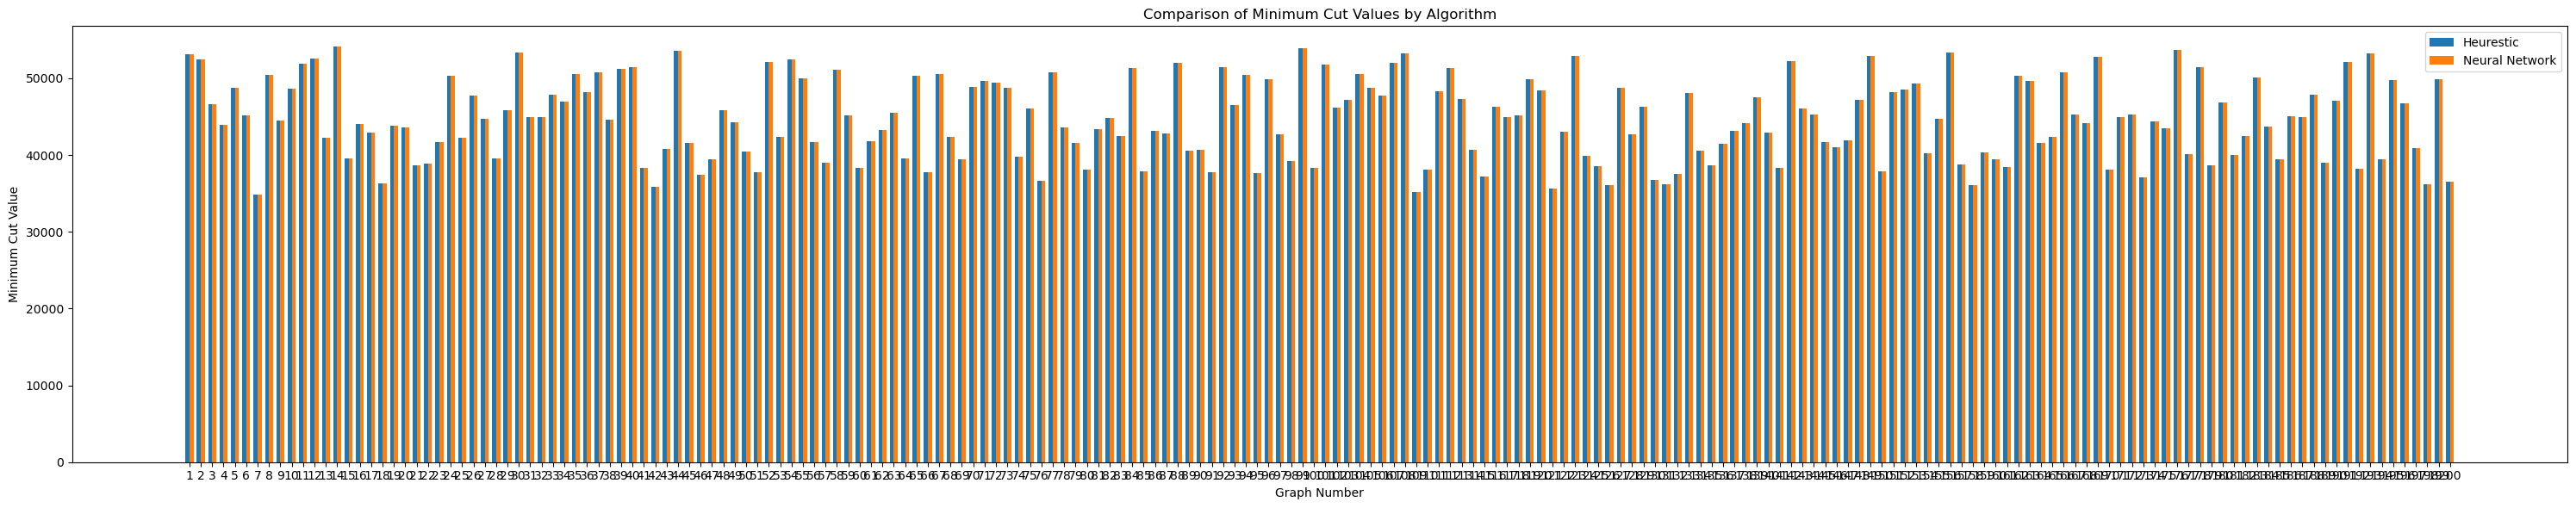

In [35]:
barPlot(indices, heurestic_cut, neural_cut)

In [36]:
percentage = 0
min_cut_value_less_than_heuristic = 0
for i in indices:
    if neural_cut[i-1] <= heurestic_cut[i-1]:
        percentage+=1
    if neural_cut[i-1] < heurestic_cut[i-1]:
        min_cut_value_less_than_heuristic+=1
print("Percentage better or equal min-cut value:" +  str(percentage))
print("Percentage better min-cut value:" +  str(min_cut_value_less_than_heuristic))

Percentage better or equal min-cut value:200
Percentage better min-cut value:3


In [64]:
test_item = {}
for i in range(100):


    graph = CreateGraph_random(100, 100)
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    test_item[i] = [graph_dgl, q_torch, graph]

indices = []
i = 0
heurestic_cut = []
neural_cut = []
for key, (dgl_graph, adjacency_matrix,graph) in test_item.items():
    heurestic_cut.append(find3WayCut(graph, [0,20,65]))
    neural_cut.append(GetOptimalNetValue(model,dgl_graph, inputs, adjacency_matrix, {0:0, 20:1, 65:2}))
    i+=1
    indices.append(i)
    print("Heurestic 3-way min-cut value: " + str(heurestic_cut[-1]))
    print("Neural Network 3-way min-cut value: " + str(neural_cut[-1]))
    print(f'-------')

Number of edges: 2715
Sample edges: [(0, 1, {'weight': 83, 'capacity': 83}), (0, 2, {'weight': 32, 'capacity': 32}), (0, 4, {'weight': 90, 'capacity': 90}), (0, 5, {'weight': 86, 'capacity': 86}), (0, 6, {'weight': 5, 'capacity': 5})]
Number of edges: 2741
Sample edges: [(0, 1, {'weight': 19, 'capacity': 19}), (0, 4, {'weight': 67, 'capacity': 67}), (0, 5, {'weight': 53, 'capacity': 53}), (0, 6, {'weight': 92, 'capacity': 92}), (0, 7, {'weight': 80, 'capacity': 80})]
Number of edges: 2707
Sample edges: [(0, 2, {'weight': 39, 'capacity': 39}), (0, 4, {'weight': 2, 'capacity': 2}), (0, 5, {'weight': 34, 'capacity': 34}), (0, 6, {'weight': 63, 'capacity': 63}), (0, 9, {'weight': 79, 'capacity': 79})]
Number of edges: 2736
Sample edges: [(0, 4, {'weight': 75, 'capacity': 75}), (0, 5, {'weight': 94, 'capacity': 94}), (0, 6, {'weight': 100, 'capacity': 100}), (0, 7, {'weight': 16, 'capacity': 16}), (0, 8, {'weight': 51, 'capacity': 51})]
Number of edges: 2760
Sample edges: [(0, 1, {'weight':

In [65]:
percentage = 0
min_cut_value_less_than_heuristic = 0
for i in indices:
    if neural_cut[i-1] <= heurestic_cut[i-1]:
        percentage+=1
    if neural_cut[i-1] < heurestic_cut[i-1]:
        min_cut_value_less_than_heuristic+=1
print("Percentage better or equal min-cut value:" +  str(percentage))
print("Percentage better min-cut value:" +  str(min_cut_value_less_than_heuristic))

Percentage better or equal min-cut value:100
Percentage better min-cut value:52


## Experiment 3

Creating training set with the following constraints:
- Each graph have precisely 300 nodes
- Each graph has random edges (50% probability of edge creation)
- Each edge has random value of 1-500

In [19]:
datasetItem = {}
for i in range(1000):


    graph = CreateGraph(random.randint(200, 500))
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    datasetItem[i] = [graph_dgl, q_torch, graph]
    print("Graph Number Created: "+str(i))

Number of edges: 110692
Sample edges: [(0, 1, {'weight': 2, 'capacity': 2}), (0, 3, {'weight': 9, 'capacity': 9}), (0, 4, {'weight': 6, 'capacity': 6}), (0, 5, {'weight': 5, 'capacity': 5}), (0, 6, {'weight': 4, 'capacity': 4})]
Graph Number Created: 0
Number of edges: 20698
Sample edges: [(0, 1, {'weight': 2, 'capacity': 2}), (0, 2, {'weight': 4, 'capacity': 4}), (0, 3, {'weight': 1, 'capacity': 1}), (0, 4, {'weight': 9, 'capacity': 9}), (0, 5, {'weight': 0, 'capacity': 0})]
Graph Number Created: 1
Number of edges: 85181
Sample edges: [(0, 1, {'weight': 7, 'capacity': 7}), (0, 2, {'weight': 0, 'capacity': 0}), (0, 3, {'weight': 3, 'capacity': 3}), (0, 5, {'weight': 0, 'capacity': 0}), (0, 6, {'weight': 6, 'capacity': 6})]
Graph Number Created: 2
Number of edges: 28131
Sample edges: [(0, 1, {'weight': 8, 'capacity': 8}), (0, 2, {'weight': 7, 'capacity': 7}), (0, 4, {'weight': 5, 'capacity': 5}), (0, 5, {'weight': 4, 'capacity': 4}), (0, 7, {'weight': 5, 'capacity': 5})]
Graph Number Cr

In [20]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=300,patience=1000)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 5,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, optimizer = get_gnn( gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

terminal_nodes = 5

trained_net, bestLost, epoch, inp= run_gnn_training(
    datasetItem, net, optimizer, int(1e3),
    gnn_hypers['tolerance'], gnn_hypers['patience'], Loss, gnn_hypers['number_classes'], './exp3.pth')

Epoch: 0, Cumulative Loss: 1446607689.53125
Epoch: 100, Cumulative Loss: 1215019994.0
Epoch: 200, Cumulative Loss: 1215019994.0
Epoch: 300, Cumulative Loss: 1215019994.0
Epoch: 400, Cumulative Loss: 1215019994.0
Epoch: 500, Cumulative Loss: 1215019994.0
Epoch: 600, Cumulative Loss: 1215019994.0
Epoch: 700, Cumulative Loss: 1215019994.0
Epoch: 800, Cumulative Loss: 1215019994.0
Epoch: 900, Cumulative Loss: 1215019994.0
GNN training took 10591.863 seconds.
Best cumulative loss: 2221670.0


In [74]:
n, d, p, graph_type, number_epochs, learning_rate, PROB_THRESHOLD, tol, patience, dim_embedding, hidden_dim = hyperParameters(n=300,patience=1000)

# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 3,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience,
    'nodes':n
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
# load nerual network model for evaluation
model, inputs =LoadNeuralModel(net, gnn_hypers, TORCH_DEVICE, './exp3.pth')
model.eval()



GCNSoftmax(
  (conv1): GraphConv(in=17, out=8, normalization=both, activation=None)
  (conv2): GraphConv(in=8, out=3, normalization=both, activation=None)
)

In [75]:

test_item = {}
for i in range(100):


    graph = CreateGraph_random(300, 500)
    graph_dgl = dgl.from_networkx(nx_graph=graph)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    q_torch = qubo_dict_to_torch(graph, gen_adj_matrix(graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

    test_item[i] = [graph_dgl, q_torch, graph]

indices = []
i = 0
heurestic_cut = []
neural_cut = []
for key, (dgl_graph, adjacency_matrix,graph) in test_item.items():
    heurestic_cut.append(find3WayCut(graph, [0,150,250]))
    neural_cut.append(GetOptimalNetValue(model,dgl_graph, inputs, adjacency_matrix, {0:0, 150:1, 250:2}))
    i+=1
    indices.append(i)
    print("Heurestic 3-way min-cut value: " + str(heurestic_cut[-1]))
    print("Neural Network 3-way min-cut value: " + str(neural_cut[-1]))
    print(f'-------')

Number of edges: 24777
Sample edges: [(0, 2, {'weight': 24, 'capacity': 24}), (0, 3, {'weight': 269, 'capacity': 269}), (0, 5, {'weight': 200, 'capacity': 200}), (0, 7, {'weight': 151, 'capacity': 151}), (0, 8, {'weight': 146, 'capacity': 146})]
Number of edges: 24583
Sample edges: [(0, 1, {'weight': 201, 'capacity': 201}), (0, 2, {'weight': 56, 'capacity': 56}), (0, 3, {'weight': 331, 'capacity': 331}), (0, 4, {'weight': 35, 'capacity': 35}), (0, 5, {'weight': 45, 'capacity': 45})]
Number of edges: 24462
Sample edges: [(0, 4, {'weight': 278, 'capacity': 278}), (0, 6, {'weight': 478, 'capacity': 478}), (0, 7, {'weight': 145, 'capacity': 145}), (0, 9, {'weight': 491, 'capacity': 491}), (0, 11, {'weight': 193, 'capacity': 193})]
Number of edges: 24607
Sample edges: [(0, 1, {'weight': 33, 'capacity': 33}), (0, 2, {'weight': 96, 'capacity': 96}), (0, 3, {'weight': 14, 'capacity': 14}), (0, 4, {'weight': 489, 'capacity': 489}), (0, 5, {'weight': 145, 'capacity': 145})]
Number of edges: 2464

In [76]:
percentage = 0
min_cut_value_less_than_heuristic = 0
for i in indices:
    if neural_cut[i-1] <= heurestic_cut[i-1]:
        percentage+=1
    if neural_cut[i-1] < heurestic_cut[i-1]:
        min_cut_value_less_than_heuristic+=1
print("Percentage better or equal min-cut value:" +  str(percentage))
print("Percentage better min-cut value:" +  str(min_cut_value_less_than_heuristic))

Percentage better or equal min-cut value:100
Percentage better min-cut value:53


In [78]:
from matplotlib.ticker import ScalarFormatter
def barPlot_2(heurestic_cut, neural_cut):
    # Example data
    n_groups = len(heurestic_cut)
    index = np.arange(n_groups)
    bar_width = 0.35

    # Create bars
    plt.figure(figsize=(30, 6))
    bar1 = plt.bar(index, heurestic_cut, bar_width, label='Heurestic', log=True)
    bar2 = plt.bar(index + bar_width, neural_cut, bar_width, label='Neural Network', log=True)

    # Add details
    plt.xlabel('Graph Number')
    plt.ylabel('Minimum Cut Value')
    plt.title('Comparison of Minimum Cut Values by Algorithm')
    plt.xticks(index + bar_width / 2, range(1, n_groups + 1))
    plt.legend()
    plt.tight_layout()
    plt.gca().yaxis.set(major_formatter=ScalarFormatter(), minor_formatter=ScalarFormatter());
    plt.show()

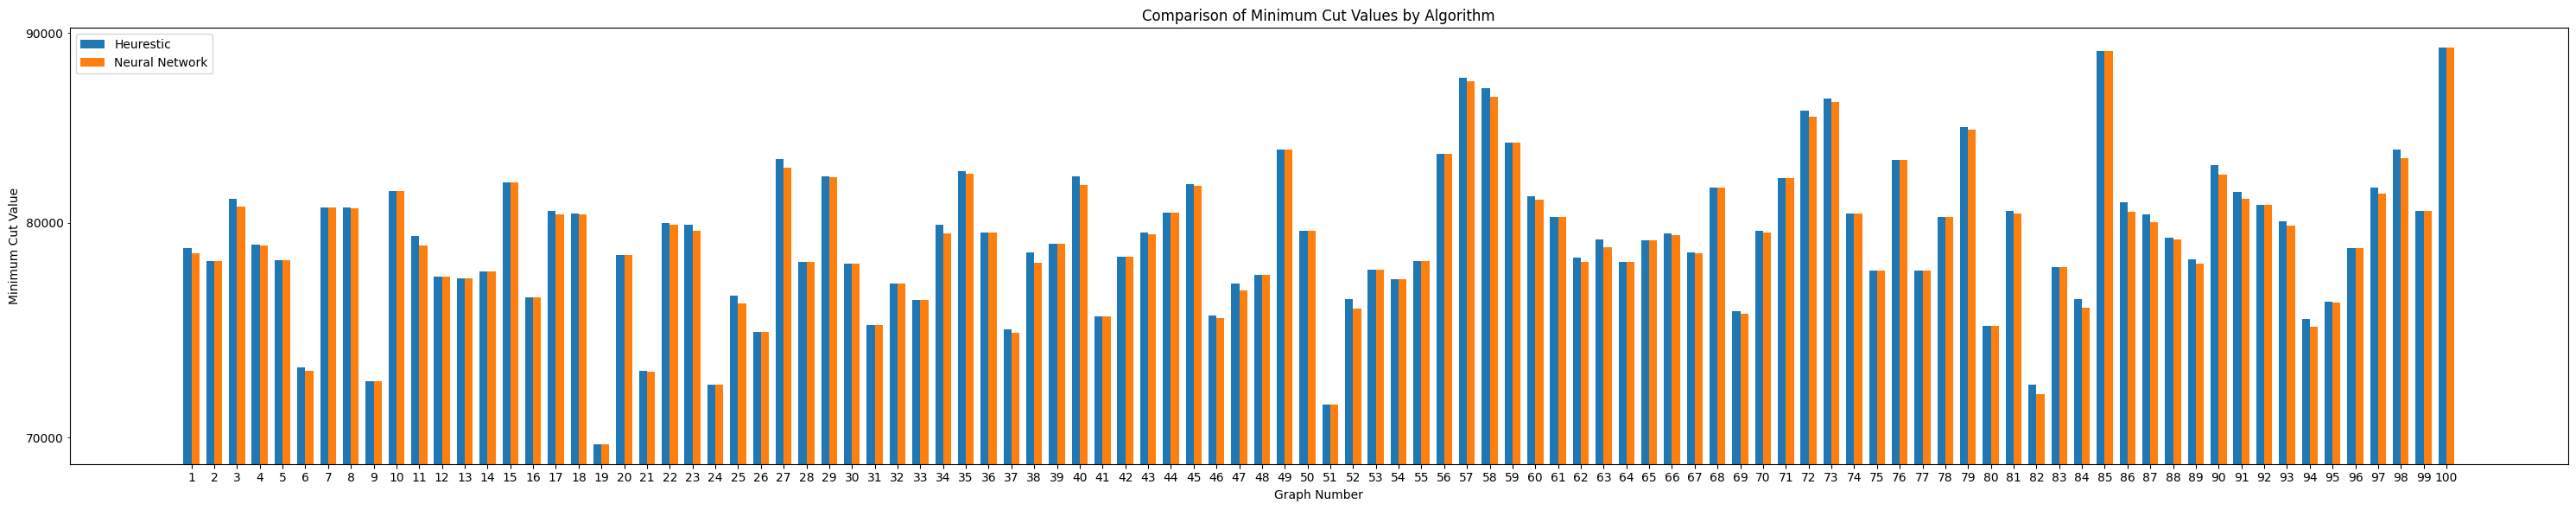

In [79]:
barPlot_2( heurestic_cut, neural_cut)